In [1]:
from math import e, log
import time
from heapq import heappush, heappop
from scipy.stats import poisson
import matplotlib.pyplot as plt
import itertools
import simpy
import numpy as np
import random
from statistics import mean
import seaborn as sns
import pandas as pd

## Generador de numeros aleatorio del TP1

In [2]:
class Xorshift_generator:
    def __init__(self, seed):
        self.x = seed
        self.y = 463820370
        self.z = 138409373
        self.w = 12872349

    def rand(self):
        tmp = ( self.x ^ (self.x << 13) ) 
        self.x = self.y
        self.y = self.z
        self.z = self.w
        self.w = (self.w^(self.w>>17) ) ^ (tmp^(tmp>>5))
        return self.w & 0xffffffff
    
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

In [3]:
class Uniform_generator:
    def __init__(self, seed, scale=1, displacement= 0):
        self.xorshift_genertor = Xorshift_generator(seed)
        self.scale = scale
        self.displacement = displacement

    def rand(self):
        n = self.xorshift_genertor.rand() / ((2**32)-1)
        return n * self.scale + self.displacement
    
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

In [4]:
class Exp_generator:
    def __init__(self, seed, parameter=1):
        self.parameter = parameter
        self.Uniform_generator = Uniform_generator(seed)

    def rand(self):
        r = self.Uniform_generator.rand()
        if self.parameter >=1:
            return log(r) / (-1 * self.parameter)
        else: 
            return -log(1 - r) / self.parameter

    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

Definimos un seed_generator que usaremos a lo largo del tp, para obtener semillas

In [5]:
class SeedGenerator:
    def __init__(self, seed):
        self.xorshift_genertor = Xorshift_generator(seed)

    def rand(self, time_dependant=True):
        seed = self.xorshift_genertor.rand()
        if time_dependant:
            seed *= int(time.time())
        return seed

In [6]:
seed_generator = SeedGenerator(123456789)

## Ejercicio 1

### Programacion tradicional

Definimos un generador de una distribucion de poisson porque lo utilizaremos mas adelante.

In [7]:
def factorial(n):
    resultado = 1
    for i in range(1, n + 1):
        resultado *= i
    return resultado

def poisson_probability(parameter, i, previous_probability):
    if previous_probability == 0:
        return poisson.pmf(i, parameter)
    return (parameter/i)*previous_probability

class Poisson_generator:
    def __init__(self, seed, parameter):
        self.parameter = parameter
        self.Uniform_generator = Uniform_generator(seed)

    def rand(self):
        r = self.Uniform_generator.rand()

        accumulated_probability = poisson_probability(self.parameter, 0, 0)
        previous_probability = accumulated_probability
        i = 0

        while(accumulated_probability < r):
            i += 1
            previous_probability = poisson_probability(self.parameter, i, previous_probability)
            accumulated_probability += previous_probability

        return i
    
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

Asumimos que el satélite da siempre la misma vuelta al mundo que tarda lo mismo, y que se puede pensar al tiempo en que tarda el satelite en llegar a una posicion a la que puede sacar una foto de la request, como una uniforme entre 0 y el tiempo en que tarda en dar la vuelta al mundo. Ya que los puntos sobre el globo se distribuyen uniformemente.

Para simular el problema lo que hacemos es definir un delta de tiempo (time step), que sera el intervalo de tiempo discreto con el que avanzaremos la simulacion. Por cada iteracion generamos un valor de una distribucion de poisson que representa la cantidad de arribos de solicitudes que llegaron en el ultimo intervalo de tiempo. Por cada solicitud de tiempo que halla llegado, generamos un valor de tiempo con una distribucion uniforme entre 0 y el satelite_period (tiempo en el que tarda en dar la vuelta al mundo el satelite), que representa el tiempo que tardara el satelite en estar en posicion para poder sacar la foto. Por cada iteracion disminuimos el tiempo restante para sacar la foto de cada request en la cola, y agregamos las nuevas. Ademas de ir anotando datos como cuantas veces hubo cada longitud de la request queue, y cuanto fue el tiempo para servir a la primera request para cada longitud de cola.

In [8]:
def simulate_satelite_request_queue_length(time_step, iterations, request_per_unit_time, satelite_period):
    generator_amount_of_request = Poisson_generator(seed_generator.rand(), request_per_unit_time*time_step)
    generator_time_to_serve = Uniform_generator(seed_generator.rand(), satelite_period)
    simulated_queue = []
    observed_queue_length = {}
    time_to_serve_first_for_queue_length = {}

    for _ in range(iterations):
        advance_time(simulated_queue, time_step)
        get_acumulated_requests(generator_amount_of_request, simulated_queue, generator_time_to_serve)    
        observed_queue_length[len(simulated_queue)] = observed_queue_length.get(len(simulated_queue), 0) + 1
        if len(simulated_queue) != 0:
            time_to_serve_first_for_queue_length.setdefault(len(simulated_queue), []).append(simulated_queue[0])
            
    return get_frequencies(observed_queue_length, iterations), get_mean_times(time_to_serve_first_for_queue_length)

In [10]:
def advance_time(simulated_queue, time_step):
    for i in range(len(simulated_queue)):
        simulated_queue[i] -= time_step

    while (len(simulated_queue) != 0 and simulated_queue[0] <= 0):
        item = heappop(simulated_queue)

def get_acumulated_requests(generator_amount_of_request, simulated_queue, generator_time_to_serve):
    amount_of_requests = generator_amount_of_request.rand()
    for request in range(amount_of_requests):
        heappush(simulated_queue, generator_time_to_serve.rand())

def get_frequencies(observed_queue_length, iterations):
    observed_frequencies = []
    for j in range(max(observed_queue_length.keys()) + 1):
        times_observed = observed_queue_length.get(j, 0)
        observed_frequencies.append(times_observed/iterations)
    return observed_frequencies

def get_mean_times(time_to_serve_for_queue_length):
    mean_times = {}

    for key in time_to_serve_for_queue_length:
        sum_of_times = 0
        for j in time_to_serve_for_queue_length[key]:
            sum_of_times += j
        mean_times[key] = sum_of_times/len(time_to_serve_for_queue_length[key])
    
    return mean_times

Simulamos un ejemplo donde tomamos que el satelite tarde 48 horas en dar la vuelta al mundo, y que llegan 10 requests por dia en promedio. Usamos un intervalo de media hora y realizamos 50 000 horas de simulacion

In [11]:
frequencies, times_to_serve_first = simulate_satelite_request_queue_length(0.5, 100000, 5/12, 48)

Podemos ver que como en general se acumulan las request hasta llegar al rededor de 10 y luego tiende a disminuir la cantidad que hay

In [14]:
def satelite_frequencies_graph(frequencies):
    x_axis = list(range(len(frequencies)))
    y_axis = frequencies
    plt.plot(x_axis, y_axis)
    plt.xlabel('Longitud de request queue')
    plt.ylabel('Frecuencia')
    plt.show()

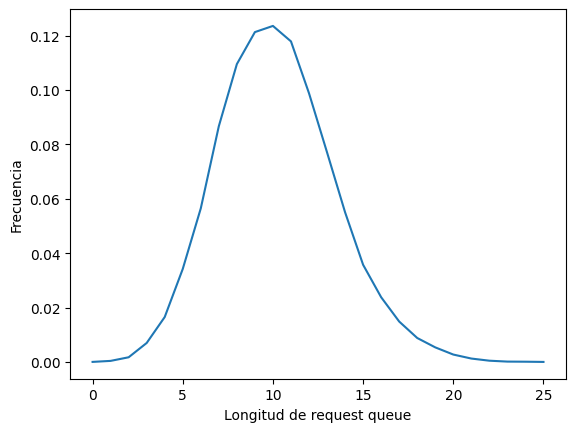

In [15]:
satelite_frequencies_graph(frequencies)

El paper llegaba a la conclusion de que cuantas mas solicitudes hayan en la cola, el tiempo que se tarda en servir estas request es menor. Para verificar esto miramos el siguiente grafico que muestra el tiempo promedio que tarda el satelite en servir al primer request de la cola.

In [16]:
def satelite_times_to_serve_first(times_to_serve_first):
    plt.bar(times_to_serve_first.keys(), times_to_serve_first.values())
    plt.xlabel("Queue length")
    plt.ylabel("Avarege time to serve first request")
    plt.show()

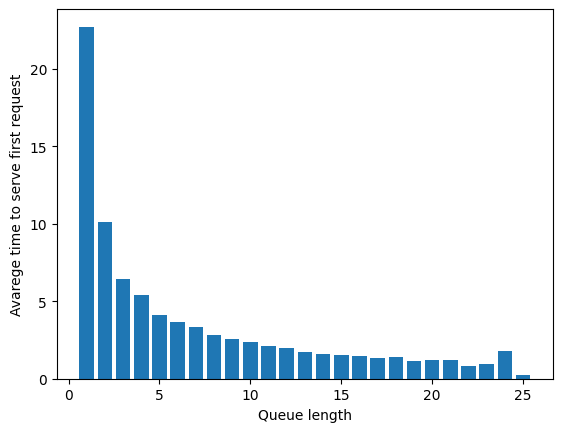

In [17]:
satelite_times_to_serve_first(times_to_serve_first)

Vemos que en este caso asi sucede, cuantas mas solicitudes hay en la cola menor es el tiempo para tomar la foto. Esto tiene sentido ya que cuantas mas request hayan en espera mas chances habra de que haya alguna mas cercana al satelite.  
Si bien el grafico solo muestra la primera request, como esto se modela como un proceso de Poisson, por propiedad de perdidad de memoria se puede ver que se cumplira para el tiempo entre todos los arribos. 

### Simpy 

Para realizar la simulacion utilizando simpy vamos a definir dos procesos. Por un lado el satelite_request_generator que va a generar request, cada un lapso de tiempo aleatorio segun una distribucion exponencial de parametro request_per_unit_time. Cada request tiene un tiempo uniforme entre 0 y satellite_period y es pusheada a la request queue que se modela como un heap. Por el otro, tendremos un proceso satelite_process_queue, que se encarga de actualizar cada un tiempo time_slice los valores de las request de la cola, y sacar cualquiera que se haya cumplido en ese lapso

In [18]:
def satelite_process_queue(env, simulated_queue, time_step, observed_queue_length, time_to_serve_first_for_queue_length):
    while True:
        yield env.timeout(time_step)
        advance_time(simulated_queue, time_step) 
        observed_queue_length[len(simulated_queue)] = observed_queue_length.get(len(simulated_queue), 0) + 1
        if len(simulated_queue) != 0:
            time_to_serve_first_for_queue_length.setdefault(len(simulated_queue), []).append(simulated_queue[0])

In [19]:
def satellite_request_gen(env, simulated_queue, satellite_period, request_per_unit_time):
    exp_generator = Exp_generator(seed_generator.rand(), request_per_unit_time)
    uni_generator = Uniform_generator(seed_generator.rand(), satellite_period)
    while True:
        time_for_next_req = exp_generator.rand()
        time_for_image = uni_generator.rand()
        yield env.timeout(time_for_next_req)
        heappush(simulated_queue, time_for_image)
        

Simulamos un ejemplo donde tomamos que el satelite tarde 48 horas en dar la vuelta al mundo, y que llegan 10 requests por dia en promedio. Usamos un intervalo de media hora y realizamos 50 000 horas de simulacion

In [25]:
env = simpy.Environment()

simulated_queue = []
observed_queue_length = {}
time_to_serve_first_for_queue_length = {}
satellite_period = 48
request_per_unit_time = 5/12
time_step = 0.5
iterations = 100000
env.process(satellite_request_gen(env, simulated_queue, satellite_period, request_per_unit_time))
env.process(satelite_process_queue(env, simulated_queue, time_step, observed_queue_length, time_to_serve_first_for_queue_length))
env.run(time_step*iterations)

Graficamos nuevamente los graficos que se hicieron con el modelo simulado con programacion principal.

In [26]:
frequencies = get_frequencies(observed_queue_length, iterations)
times_to_serve_first = get_mean_times(time_to_serve_first_for_queue_length)

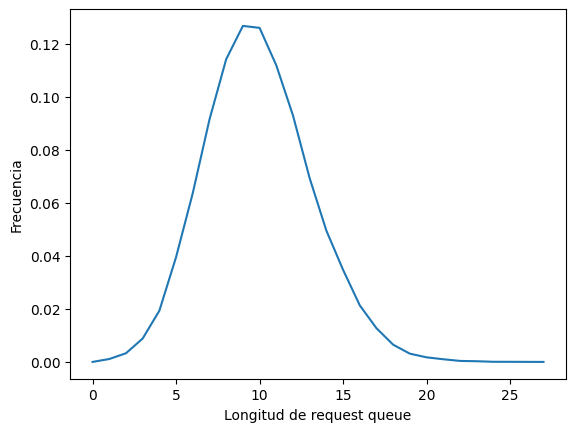

In [23]:
satelite_frequencies_graph(frequencies)

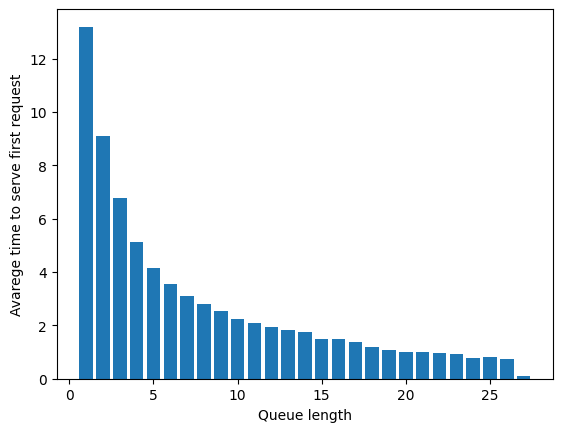

In [24]:
satelite_times_to_serve_first(times_to_serve_first)

Vemos que los resultados obtenidos son muy similares, y podemos llegar a la misma conclusion, ya que nuevamente vemos como dismuye el tiempo que tarda en llegar a la posicion en la que se toma la primera foto a medida que aumentan las solicitudes en la cola.

## Ejercicio 2

### Simulacion

In [27]:
SIM_TIME = 7 * 24 * 60 # Una semana en minutos  

Para facilitar la simulacion de las dos maquinas definiremos una clase Machine, que nos permitira definir cuantas maquinas utilizamos en la simulacion. Dentro de esta clase guardamos informacion util, asi como tambien en una segunda clase auxiliar llamada RequestQueueStats. 

In [28]:
class Machine:
    
    def __init__(self,id):
        self.working_time = 0
        self.requests_taken = 0
        self.id = id
        self.req_time_stats = []
        self.procesing_requests = False
    
    def process_request(self, request):
        self.requests_taken += 1
        self.working_time += request

    def add_req_time_stat(self, time_tup):
        # The tuple has the following format: (req_buffer_time, req_system_time)
        self.req_time_stats.append(time_tup)

    def is_processing_requests(self):
        return self.procesing_requests

class RequestQueueStats:
    def __init__(self, queue_length):
        self.queue_length = queue_length
        self.rejected_requests = 0
        self.total_requests = 0
        self.amount_of_requests_in_queue = []
        self.amount_of_requests_in_system = []

    def inc_rejected_requests(self):
        self.rejected_requests +=1
        self.total_requests +=1
    
    def inc_accepted_requests(self):
        self.total_requests +=1

    def rejected_ratio(self):
        return self.rejected_requests / self.total_requests
    
    def add_amount_of_requests_in_queue(self, amount_of_requests):
        self.amount_of_requests_in_queue.append(amount_of_requests)

    def add_amount_of_requests_in_system(self, amount_of_requests):
        self.amount_of_requests_in_system.append(amount_of_requests)

    def mean_amount_of_requests_in_queue(self):
        aux = mean(self.amount_of_requests_in_queue)
        print(f"cantidad media de elementos en el buffer: {aux}")
        return aux

    def mean_amount_of_requests_in_system(self):
        aux = mean(self.amount_of_requests_in_system)
        print(f"cantidad media de elementos en el buffer: {mean(self.amount_of_requests_in_system)}")
        return aux
        

Vamos a definir 3 procesos para la simulacion con simpy

Request_generator se encarga de generar la llegada de solicitudes al sistema, que llegan distribuidas como un proceso de poisson de parametro 10. Una vez generada la request se envia a una cola donde esperan que alguna de las maquinas de la simulacion las procese.

In [33]:
def request_generator(env, requests_buffer, seed, requests_stats, request_queue_size):
    """Las solicitudes llegan siguiendo un proceso Poisson con una frecuencia media de 10
    por minuto. Por ende el tiempo entre 2 solicitudes consecutivas seguira una distribucion
    Exponencial de parametro 10."""
    exponential_gen = Exp_generator(seed, 10) 
    
    for i in itertools.count():
        time_for_next_request = exponential_gen.rand()
        yield env.timeout(time_for_next_request)

        if len(requests_buffer.items) == request_queue_size:
            requests_stats.inc_rejected_requests() 
        else:
            requests_stats.inc_accepted_requests()
            yield requests_buffer.put(env.now)


Procesing machine se encarga de simular el procesamiento de las maquinas, estas toman una request del request_buffer para simular el tioempo que se demora en procesar. Este tiempo dependera del tipo de maquina que se este usando

In [34]:
def processing_machine(env, requests_center, requests_buffer, seed, machine, new_machine):
    exponential_gen = Exp_generator(seed, 6)
    
    while True:
        
        time_to_process = 0.01
        request_processed = False
        with requests_center.request() as req:
            yield req
            
            if len(requests_buffer.items) != 0:
                machine.procesing_requests = True
                arrival_time = yield requests_buffer.get()
                buffer_time = env.now - arrival_time
                if new_machine:
                    time_to_process = 5/60
                else: 
                    time_to_process = exponential_gen.rand()

                machine.process_request(time_to_process)
                request_processed = True
          
        # If there are no requests to process in the buffer, the timeout is of 0 seconds.
        yield env.timeout(time_to_process)
        if request_processed:
            machine.procesing_requests = False
            system_time = env.now - arrival_time
            time_tup = (buffer_time, system_time)
            machine.add_req_time_stat(time_tup)

Finalmente definiremos un ultimo proceso, para ayudarnos a la hora de tomar estadisticas. Esencialmente lo que hace este proceso es tomar una foto del estado de la simulacion cada 1 segundo y guardarlo ya sea en la machine o en el request_queue_stats.

In [35]:
def buffer_stats(env, buffer, requests_queue_stats, machines):
    while True:
        requests_in_buffer = len(buffer.items)
        requests_queue_stats.add_amount_of_requests_in_queue(requests_in_buffer)
        requests_in_system = requests_in_buffer
        for machine in machines:
            if machine.is_processing_requests():
                requests_in_system += 1

        requests_queue_stats.add_amount_of_requests_in_system(requests_in_system)
        yield env.timeout(1/60)

Con processing_center_simulation se nos permite decidir que evento queremos simular (con las 2 maquinas viejas o con 1 maquina nueva). Ademas, recibe como parametro el tamaño de la request_queue que influye en el comportamiento de la simulacion.

In [38]:
def processing_center_simulation(request_queue_size, amount_of_machines ,new_system):
    env = simpy.Environment()
    requests_center = simpy.Resource(env, 1)
    requests_buffer = simpy.Store(env, request_queue_size)
    requests_queue_stats = RequestQueueStats(request_queue_size)
    env.process(request_generator(env, requests_buffer, seed_generator.rand(), requests_queue_stats, request_queue_size))

    machines = []
    for i in range(amount_of_machines):
        machine = Machine(i)
        machines.append(machine)
        env.process(processing_machine(env, requests_center, requests_buffer, seed_generator.rand(), machine, new_system))
    env.process(buffer_stats(env, requests_buffer, requests_queue_stats, machines))

    env.run(until=SIM_TIME)

    return machines, requests_queue_stats


Simulamos las 2 maquinas con el sistema viejo tomando un tama;o arbitrario de la cola de 15.

In [39]:
machines, request_queue_stats = processing_center_simulation(15, 2, False)

### Estadisticas

Calculamos estadisticas utilizando los datos recolectados durante la simulacion

Ocupation factor de cada maquina

In [40]:
m1_ocupation_factor = machines[0].working_time/SIM_TIME
m2_ocupation_factor = machines[1].working_time/SIM_TIME
ocupation_factor = (machines[0].working_time + machines[1].working_time)/(SIM_TIME*2)
print(f"machine 1 ocupation_factor: {m1_ocupation_factor}")
print(f"machine 2 ocupation_factor: {m2_ocupation_factor}")
print(f"ocupation_factor: {ocupation_factor}")


machine 1 ocupation_factor: 0.8213685588640751
machine 2 ocupation_factor: 0.819759882924049
ocupation_factor: 0.820564220894062


Cantidad media de elementos en el buffer

In [43]:
mean_amount_of_requests_in_queue = request_queue_stats.mean_amount_of_requests_in_queue()

cantidad media de elementos en el buffer: 2.9594891542838058


Calculamos la cantidad media de solicitudes en el sistema

In [46]:
_ = request_queue_stats.mean_amount_of_requests_in_system()

cantidad media de elementos en el buffer: 4.600539681647351


Average request time in buffer

In [48]:
def avg_request_time(machines, index):
    time_in_buffer = 0
    total_amount_of_requests = 0
    for machine in machines:
        total_amount_of_requests += len(machine.req_time_stats)
        for time_tup in machine.req_time_stats:
            time_in_buffer += time_tup[index]
    return time_in_buffer/total_amount_of_requests

In [49]:
avg_buff_time = avg_request_time(machines, 0)

print(f"Average time in buffer: {avg_buff_time} minutes")
print(f"Average time in buffer: {avg_buff_time*60} seconds")

Average time in buffer: 0.29987391126520724 minutes
Average time in buffer: 17.992434675912435 seconds


Average time in system

In [51]:
avg_sys_time = avg_request_time(machines, 1)

print(f"avg time in system: {avg_sys_time} minutes")
print(f"avg time in system: {avg_sys_time*60} seconds")

avg time in system: 0.46617638615796364 minutes
avg time in system: 27.97058316947782 seconds


Determinar el tamaño del buffer para que la probabilidad de que NO haya lugar para recibir solicitudes sea
como mucho 3%.

Para verificar que se rechazan como mucho 3% de las solucitudes lo que hacemos es calcular el rejected ratio, es decir cuantas solicitudes no entraron en el buffer dividido la cantidad de solicitudes totales. Si bien este resultado depende de la muestra, consideramos que es confiable debido a la alta cantidad de muestras (que se toman cada 1 segundo), dado a que simulamos una semana de tiempo

Usando lo ya simulado con una cola de tamaño 15 vemos que el rejected_ratio cumple con ser menor a 0.03

In [52]:
request_queue_stats.rejected_ratio()

0.008393058282911854

Como ya sabemos que con longitud 15 se cumple que el rejected ratio sea menor a 0.03, para obtener cual es el menor valor de longitud de la request_queue, simulamos reduciendo la longitud de la misma hasta que no se cumpla la condicion.

In [54]:
queue_size = 15
rejected_ratio = request_queue_stats.rejected_ratio()
while rejected_ratio < 0.03:
    queue_size -= 1
    _, aux_request_queue_stats = processing_center_simulation(queue_size, 2,False)
    rejected_ratio = aux_request_queue_stats.rejected_ratio()
    print(f"El rejected ratio con una longitud de cola {queue_size}  = {rejected_ratio}")
print(f'El mayor tamaño de cola que no cumple la condicion es {queue_size}, por lo que el menor tamaño de buffer con el que conseguimos un rejected ratio menor a 0.03 es {queue_size + 1}')

El rejected ratio con una longitud de cola 14  = 0.011728456415863234
El rejected ratio con una longitud de cola 13  = 0.01362362875858259
El rejected ratio con una longitud de cola 12  = 0.016184593454891014
El rejected ratio con una longitud de cola 11  = 0.015557982525814138
El rejected ratio con una longitud de cola 10  = 0.02302428123940065
El rejected ratio con una longitud de cola 9  = 0.02598680287792662
El rejected ratio con una longitud de cola 8  = 0.035361858433435915
El mayor tamaño de cola que no cumple la condicion es 8, por lo que el menor tamaño de buffer con el que conseguimos un rejected ratio menor a 0.03 es 9


Evaluar la posibilidad de reemplazar las dos máquinas por una sola que procesa todos las solicitudes en
un tiempo fijo de 5 segundos. Si el costo de tener solicitudes en el buffer es 0,2 USD/minuto y el costo
de modificar la máquina es 2000 USD, Cuánto tiempo tomará amortizar el inversión?

Para ver en cuanto tiempo se amortiza la nueva maquina, consideramos que se debe pagar 0,2 por cada tarea por cada minuto que este en el sistema. En promedio, cada sistema genera un gasto por minuto de cantidad_media_en_el_buffer * 0,2. Si queremos obtener en que momento se amortiza la inversion inicial de la nueva maquina tenemos que plantear la siguiente ecuacion.  
(cantidad_media_en_el_buffer_del_viejo_sistema *0,2)t = (cantidad_media_en_el_buffer_del_nuevo_sistema*0,2)t + 2000  
despejando t obtenemos  
t = 2000 / (cantidad_media_en_el_buffer_del_viejo_sistema *0,2 - cantidad_media_en_el_buffer_del_nuevo_sistema*0,2) 

In [55]:
mean_amount_of_requests_in_queue_old_system = mean_amount_of_requests_in_queue

Simulamos con una cola de igual longitud bajo el nuevo sistema

In [57]:
_, request_queue_stats = processing_center_simulation(15, 1, True)
mean_amount_of_requests_in_queue_new_system = request_queue_stats.mean_amount_of_requests_in_queue()

cantidad media de elementos en el buffer: 2.10783546984876


Calculamos el tiempo medio hasta amortizar la inversion inicial

In [167]:
time_to_break_even = 2000 / (mean_amount_of_requests_in_queue_old_system * 0.2 - mean_amount_of_requests_in_queue_new_system * 0.2)
print(f"Se tardarian {time_to_break_even} minutos")
time_to_break_even = time_to_break_even/60
print(f"Se tardarian {time_to_break_even} horas")
time_to_break_even = time_to_break_even/24
print(f"Se tardarian {time_to_break_even} dias")

Se tardarian 10281.587183397167 minutos
Se tardarian 171.35978638995277 horas
Se tardarian 7.139991099581366 dias


## EJERCICIO 3

In [123]:
SIM_TIME_3 = 30 * 24

Para simular este evento, tenemos la clase Truck, de la cual se creara una instancia por cada camion que llegue al centro de distribucion. Dentro de la clase podemos guardar sus tiempos que nos serviran para las estadisticas y ademas tiene como metodo a la funcion download_shipment que simulara el camion tratando de descargar su carga, pero solo si consigue alguna de las 4 darsenas que pueden estar ocupadas por otros camiones, si no consigue darsena, se queda esperando hasta conseguir una.

In [158]:
class Truck:

    def __init__(self, env, id, arrival_time):
        self.env = env
        self.id = id
        self.arrival_time = arrival_time
        self.download_shipment_time = None
        self.finish_time = None


    def download_shipment(self, distribution_center, exp_generator):
        
        with distribution_center.request() as req:
            yield req
            self.download_shipment_time = env.now
            time_to_download = exp_generator.rand()

            yield env.timeout(time_to_download)
            self.finish_time = env.now

Definimos tambien el proceso truck_generator que se encarga de simular el arribo de camiones, y crear una instancia de la calse camion. Ademas dependiendo del tipo de sistema de identificacion, se usaran distintos generadores para determinar el tiempo de descarga.

In [159]:
def truck_generator(env, distribution_center, trucks, id_type, trucks_per_unit_time):
    arraival_time_generator = Exp_generator(seed_generator.rand(), trucks_per_unit_time)
    if id_type == 'barcode':
        download_time_generator = Exp_generator(seed_generator.rand(), 2)
    else:
        download_time_generator = Exp_generator(seed_generator.rand(), 12/5)

    for i in itertools.count():
        time_for_next_truck = arraival_time_generator.rand()
        yield env.timeout(time_for_next_truck)
        
        truck = Truck(env, i, env.now)
        env.process(truck.download_shipment(distribution_center, download_time_generator))
        trucks.append(truck)

Simulamos el sscenario en el que se usa codigo de barras para descargar y hay 4 darsenas

In [171]:
env = simpy.Environment()
distribution_center = simpy.Resource(env, 4)

trucks = []
env.process(truck_generator(env, distribution_center, trucks, 'barcode', 5))
env.run(SIM_TIME_3)

Obtenemos la cantidad media de camiones en el sistema y en el buffer

In [172]:
def mean_trucks_quantity(trucks):
    # We cheack for every second how many trucks were in the system, buffer, their times, etc.
    system_quantity = []
    buffer_quantity = []
    curr_time = 0
    while curr_time < SIM_TIME_3:
        trucks_in_system = 0
        trucks_in_buffer = 0
        for truck in trucks:
            if not all([truck.download_shipment_time,truck.finish_time]):
                # If the truck never got out of the buffer or system before the simulation ended, their times cannot be taken into account
                continue

            if truck.arrival_time < curr_time < truck.finish_time:
                trucks_in_system += 1

            if truck.arrival_time < curr_time < truck.download_shipment_time:
                trucks_in_buffer += 1
        system_quantity.append(trucks_in_system)
        buffer_quantity.append(trucks_in_buffer)
        curr_time += 0.2

    print("mean trucks in system ",mean(system_quantity))
    print("mean trucks in buffer ",mean(buffer_quantity))



In [173]:
mean_trucks_quantity(trucks)

mean trucks in system  3.1858333333333335
mean trucks in buffer  0.6375


Obtenemos el tiempo media de cada camion en el buffer y en el sistema

In [174]:
def mean_trucks_time(trucks):
    collective_time_in_system = 0
    collective_time_in_buffer = 0
    for truck in trucks:
        if not all([truck.download_shipment_time,truck.finish_time]):
                # If the truck never got out of the buffer or system before the simulation ended, their times cannot be taken into account
                continue
        collective_time_in_buffer += truck.download_shipment_time - truck.arrival_time
        collective_time_in_system += truck.finish_time - truck.arrival_time
    print("mean trucks system time ",collective_time_in_system/len(trucks))
    print("mean trucks buffer time ",collective_time_in_buffer/len(trucks))

In [175]:
mean_trucks_time(trucks)

mean trucks system time  0.629609493141433
mean trucks buffer time  0.12594225620178723


Simulamos el sscenario en el que se usa RFID para descargar y hay 3 darsenas

In [176]:
env = simpy.Environment()
distribution_center = simpy.Resource(env, 3)

trucks = []
env.process(truck_generator(env, distribution_center, trucks, 'rfid', 5))
env.run(SIM_TIME_3)

Calculamos las misma estadisticas que antes

In [177]:
mean_trucks_time(trucks)

mean trucks system time  0.597698168589465
mean trucks buffer time  0.18903718535775918


In [178]:
mean_trucks_quantity(trucks)

mean trucks in system  2.987222222222222
mean trucks in buffer  0.94


Vemos que a pesar de haber cerrado una darsena, gracias al nuevo sistema rfid, la cantidad de camiones en promedio que deben esperar en la cola es alrededor de 1. Como esta media es < 3 se deberia cerrar la darsena. Como el resultado nos dio bastante alejado de 3 lo podemos decir mayor seguridad.

## EJERCICIO 4

In [179]:
SIM_TIME_4 = 24 * 60 # 1000 dia en minutos
TIMES_SIM = 1000 # Cantidad de dias a simular

Definimos un Atm nuevo que tiene caja recicladora. Esta clase sera muy util durante la simulacion ya que sera la instancia que lleve la cuenta de los diversos datos que usaremos para obtener las estadisticas. Los clientes pueden depositar y extraer billetes del cajero siempre que este tenga suficiente billetes

In [189]:
class AtmRecycler:
    
    def __init__(self, box_size, initial_bills):
        self.successfull_extractions = 0
        self.successfull_deposits = 0
        self.failed_extractions = 0
        self.failed_deposits = 0

        self.box_size = box_size
        self.bills = initial_bills
        self.bill_tracker = [initial_bills]
        self.clients_served = []

    def deposit(self, client, amount):
        if amount + self.bills > self.box_size:
            self.failed_deposits +=1
            return 0
        self.bills += amount
        self.successfull_deposits +=1
        self.bill_tracker.append(self.bills)
        self.clients_served.append(client)
        return amount
    
    def extraction(self,client, amount):
        if amount > self.bills:
            self.failed_extractions +=1
            return 0
        self.bills -= amount
        self.successfull_extractions +=1
        self.bill_tracker.append(self.bills)
        self.clients_served.append(client)
        return amount
    
    def print_stats(self):
        print("depositos_exitosos                ", self.successfull_deposits)
        print("depositos_fallidos                ", self.failed_deposits)
        print("extracciones_exitosas             ", self.successfull_extractions)
        print("extracciones_faliidas             ", self.failed_extractions)
        print("billetes en la caja al finalizar  ", self.bills)
        print("ratio de extracciones fallidas    ", self.ratio_of_rejected_extractions())

    def ratio_of_rejected_extractions(self):
        return self.failed_extractions / (self.failed_extractions + self.successfull_extractions)
    
    def ratio_of_rejected_deposits(self):
        return self.failed_deposits / (self.failed_deposits + self.successfull_deposits)
    
    def ratio_of_rejected_transactions(self):
        return (self.failed_deposits + self.failed_extractions) / (self.failed_deposits + self.failed_extractions + self.successfull_deposits + self.successfull_extractions)

Tambien tenemos a la clase cliente. Esta nos permite modelar el comportamiento acotado de los clientes en nuestro sistema. Estos pueden depositar o extrar billetes del cajero siempre y cuando este no este siendo usado por un cliente que llego antes, similar a lo que pasaba con los camiones.

In [190]:
class Client:
    def __init__(self, atm, resource, arrival_time):
        self.atm = atm
        self.resource = resource
        self.arrival_time = arrival_time
        self.finish_time = 0

    def deposit(self, env, time_to_deposit, amount):
        with self.resource.request() as req:
            yield req
            yield env.timeout(time_to_deposit)
            self.atm.deposit(self, amount)
            self.finish_time = env.now

    def extraction(self, env, time_to_extract, amount):
        with self.resource.request() as req:
            yield req
            yield env.timeout(time_to_extract)
            self.atm.extraction(self, amount)
            self.finish_time = env.now


Con arrival_of_clients tenemos un proceso que instancia clientes que pueden extraer o depositar en el cajero que es compartido por todos.

In [191]:
def arrival_of_clients(env, atm, resource, day):
    time_gen = Exp_generator(seed_generator.rand(), 1/10) # Generador de tiempo entre llegada de clientes
    transaction_gen = Uniform_generator(seed_generator.rand()) # Generador de probabilidad para extraccion o deposito
    
    extraction_time_gen = Exp_generator(seed_generator.rand(), 2/3) # Generador de tiempo para extracciones
    deposit_time_gen = Exp_generator(seed_generator.rand(), 1/5) # Generador de tiempo para depositos

    extraction_amount_gen = Uniform_generator(seed_generator.rand(), 47, 3) # Generador de cantidad de billetes a extraer
    deposit_amount_gen = Uniform_generator(seed_generator.rand(), 100, 10) # Generador de cantidad de billetes a depositar
    
    while True:
        time_for_next_client = time_gen.rand()
        yield env.timeout(time_for_next_client)
        client = Client(atm, resource, env.now)

        if transaction_gen.rand() < 0.75:
            time_to_extract = extraction_time_gen.rand()
            amount = int(extraction_amount_gen.rand())
            env.process(client.extraction(env, time_to_extract, amount))
        else:
            time_to_deposit = deposit_time_gen.rand()
            amount = int(deposit_amount_gen.rand())
            env.process(client.deposit(env, time_to_deposit, amount))

Por ultimo, days_of_work genera una simulacion por cada dia y nos permite decidir cuantos dias queremos simular. Lo que nos devuelve es una lista que contiene instancias del cajero (1 instancia por dia simulado) que luego nos sirve para conseguir estadisticas.

In [192]:
def days_of_work(n, initial_bills):
    atms = []
    for i in range(1, n + 1):
        env = simpy.Environment()
        resource = simpy.Resource(env, 1)
        atm = AtmRecycler(2000, initial_bills)
        env.process(arrival_of_clients(env, atm, resource, i))
        env.run(until=SIM_TIME_4)
        atms.append(atm)
    return atms

Simulamos 1000 dias de un cajero que inicia con 2000 billetes

In [193]:
atms = days_of_work(1000, 2000)

Cantidad de billetes en un dia luego de cada transaccion

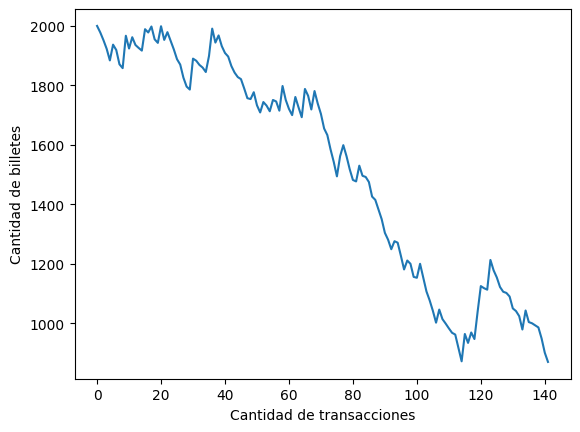

In [194]:
def plot_bill_tracker(atm):
    plt.plot(atm.bill_tracker)
    plt.xlabel("Cantidad de transacciones")
    plt.ylabel("Cantidad de billetes")
    plt.show()

plot_bill_tracker(atms[0])

En promedio arriban al cajero 144 clientes por dia. En promedio el 75% de ellos va a querer extraer, y el otro 25% depositar. Si tomamos el valor medio de cada cliente que quiere extraer/depositar, obtenemos que por dia se extraen una cantidad neta de billetes (tomando que no se rechaza ninguna transaccion).  

In [195]:
(144 * 0.75 * (53 / 2)) - (144 * 0.25 *60)

702.0

Es decir que se retiran en promedio 702 billetes del cajero por dia

Vemos claramente que hay mas extracciones de billetes que deposito de los mismos. Es decir que el cajero eventualemte se quedara sin dinero y debera depender de los depositos hasta que se rellene el cajero. Pensando desde el punto vista del banco, queremos maximizar el tiempo en el que ambas operaciones son realizables. Pensando de esta manera, los depositos son muy valiosos, ya que permiten que se realicen futuras extracciones y son muchos menos los que hay. Si inicializamos el cajero en el tama;o maximo de la caja, como se hizo en la anterior simulacion tenderemos a rechazar los primeros depositos, que es algo totalmente evitable, mejorando la cantidad inicial de billetes. Para esto buscaremos mejorar las metricas de rejected_ratio

In [196]:
def get_mean_ratios(atms):
    rej_t_ratio = []
    rej_d_ratio = []
    rej_e_ratio = []
    for atm in atms:
        rej_t_ratio.append(atm.ratio_of_rejected_transactions())
        rej_d_ratio.append(atm.ratio_of_rejected_deposits())
        rej_e_ratio.append(atm.ratio_of_rejected_extractions())
    mean_rej_t = mean(rej_t_ratio)
    mean_rej_d = mean(rej_d_ratio)
    mean_rej_e = mean(rej_e_ratio)
    print(f"Se rechazaron transacciones con un ratio de: {mean_rej_t}")
    print(f"Se rechazaron deposits con un ratio de:      {mean_rej_d}")
    print(f"Se rechazaron extractions con un ratio de:   {mean_rej_e}")
    return [mean_rej_t, mean_rej_d, mean_rej_e]

In [197]:
rejection_ratios_2000 = get_mean_ratios(atms)

Se rechazaron transacciones con un ratio de: 0.018359078034360817
Se rechazaron deposits con un ratio de:      0.06859621234822018
Se rechazaron extractions con un ratio de:   0.00020768179830307705


Vemos que el ratio de rechazos es muy chico en general, sin embargo la mayoria proviene de los depositos, y queremos ver si con un menor numero inicial de billetes mejora. Ademas esto es lo que buscara el banco, si rellena cada 1 dia, quiere rellenar con la menor cantidad de billetes posibles sin que empeoren las estadisticas

Por ejemplo podemos probar iniciando, con 1900 billetes

In [199]:
atms = days_of_work(1000, 1900)

In [200]:
rejection_ratios_1900 = get_mean_ratios(atms)

Se rechazaron transacciones con un ratio de: 0.0101721641505224
Se rechazaron deposits con un ratio de:      0.03619015421912959
Se rechazaron extractions con un ratio de:   0.0003544143386673828


In [202]:
def plot_ratios(amount_of_bills, rejection_ratios):
    categories = ["transactions", "deposit", "extractions"]
    positions = np.arange(len(categories))
    ancho=0.1
    for i in range(len(rejection_ratios)):
        plt.bar(positions + ancho*i, rejection_ratios[i], ancho)

    plt.legend(amount_of_bills)
    plt.xticks(positions + ancho, ["transactions", "deposit", "extractions"])
    plt.ylabel('Ratio de rechazos')

    plt.show()

Podemos ver como influye en los ratios de rechazos la cantidad inicial de billetes en el cajero.

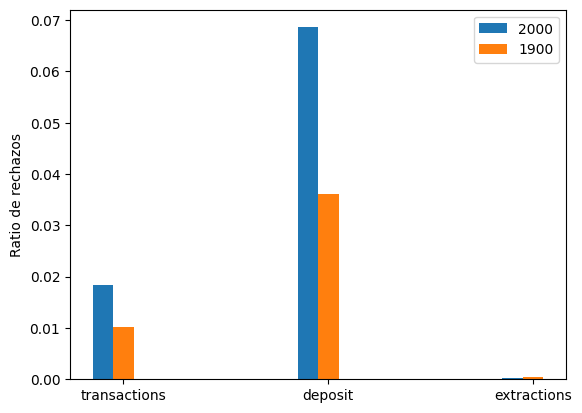

In [203]:
plot_ratios([2000,1900], [rejection_ratios_2000, rejection_ratios_1900])

Vemos que las metricas mejoraron ampliamente, los depositos rechazados se redujeron a casi la mitad, al igual que las trasacciones totales, rechazadas, mientras que las extracciones rechazadas casi no se movieron. 

Vamos a buscar minimizar entonces la cantidad de transacciones rechazadas, independientemente de que tip sean

In [204]:
previous_transaction_rejected_ratio = rejection_ratios_1900[0]
current_transaction_rejected_ratio = rejection_ratios_1900[0]
i = 1900

bill_amount_ratio = {}
while (current_transaction_rejected_ratio <= previous_transaction_rejected_ratio ):
    i -= 50
    previous_transaction_rejected_ratio = current_transaction_rejected_ratio
    atms = days_of_work(1000, i)
    
    print(f"\nRatios con {i} billetes")
    current_rejected_ratios = get_mean_ratios(atms)
    bill_amount_ratio[i] = current_rejected_ratios
    current_transaction_rejected_ratio = current_rejected_ratios[0]


Ratios con 1850 billetes
Se rechazaron transacciones con un ratio de: 0.008073838727331943
Se rechazaron deposits con un ratio de:      0.02657977528705729
Se rechazaron extractions con un ratio de:   0.0008416802883496559

Ratios con 1800 billetes
Se rechazaron transacciones con un ratio de: 0.00691465679338044
Se rechazaron deposits con un ratio de:      0.02173219123455569
Se rechazaron extractions con un ratio de:   0.0007760130285777167

Ratios con 1750 billetes
Se rechazaron transacciones con un ratio de: 0.004612142525046905
Se rechazaron deposits con un ratio de:      0.013629687683255265
Se rechazaron extractions con un ratio de:   0.0008975836512336527

Ratios con 1700 billetes
Se rechazaron transacciones con un ratio de: 0.004468829169687955
Se rechazaron deposits con un ratio de:      0.012643978879919254
Se rechazaron extractions con un ratio de:   0.0009211256849002512

Ratios con 1650 billetes
Se rechazaron transacciones con un ratio de: 0.003276670278631417
Se rechazar

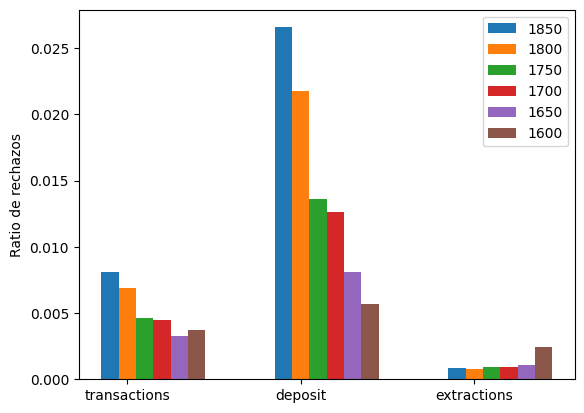

In [206]:
plot_ratios(list(bill_amount_ratio.keys()), list(bill_amount_ratio.values()))

Vemos que a medida que reducimos la cantidad de billetes disminuye enormemente la canitdad de depositos rechazados, mientras que aumenta ligeramente la cantidad de extracciones rechazadas. Esto continua asi, hasta la ultima iteracion donde aumenta mas la cantidad de transacciones rechazadas que en la iteracion anterior. Entonces El menor numero de transacciones rechazadas sera el valor de la anteultima iteracion. Esto tiene otro beneficio, que es que el banco necesita menos billetes para reponer cada cajero.

In [208]:
best_bill_amount = min(bill_amount_ratio.keys()) + 50
print(f"La cantidad de billetes para minimizar las transacciones rechazadas es {best_bill_amount}")

La cantidad de billetes para minimizar las transacciones rechazadas es 1650


Cabe destacar, que dependiendo de la muestra obtenida al simular, la mejor cantidad de billetes puede variar. Las veces que lo simulamos obtuvimos valores entre 1600 y 1700

Realizamos entonces nuevamente las estadisticas para un cajero que inicia con la mejor cantidad de billetes obtenida

In [217]:
atms = days_of_work(1000, best_bill_amount) 

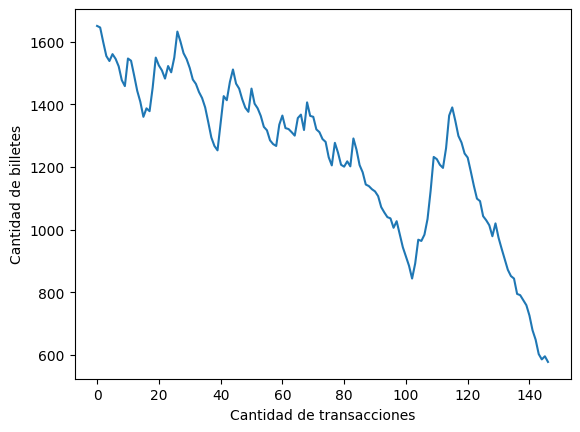

In [218]:
plot_bill_tracker(atms[0])

In [219]:
get_mean_ratios(atms)

Se rechazaron transacciones con un ratio de: 0.00420738940274744
Se rechazaron deposits con un ratio de:      0.008737086168193388
Se rechazaron extractions con un ratio de:   0.0019320239369416711


[0.00420738940274744, 0.008737086168193388, 0.0019320239369416711]

Calculamos el tiempo medio que tardan los clientes en el sistema

In [220]:
amount_of_clients = 0
collective_clients_spent_time = 0
for atm in atms:
    amount_of_clients += len(atm.clients_served)
    for client in atm.clients_served:
        collective_clients_spent_time += client.finish_time - client.arrival_time
print(f'El tiempo medio de los clientes en el sistema es de: ' ,collective_clients_spent_time/amount_of_clients)

El tiempo medio de los clientes en el sistema es de:  3.390852198938373


¿Recomienda a la entidad que implemente el cambio de cajero?

La entidad acepta el cambio de cajero, si se reduce de un 20% la cantidad de clientes rechazados a la hora de querer una extraccion. Como ya mostramos este numero esta siempre debajo del 1%, por lo que claramente se mejoraria mucho esta metrica. No solo eso si no que tambien como ya se mostro se puede reducir la cantidad de billetes necesarios que tenga el cajero al inicio de cada dia. Por lo que definitivamente se le recomienda a la entidad cambiar al nuevo sistema. 